# 🤖 Modelado Predictivo del Dataset

En esta sección se construyen modelos predictivos para estimar la probabilidad de éxito (*target*) de cada candidato.  
El objetivo es:

- Entrenar modelos supervisados que capturen la relación entre variables explicativas y target
- Evaluar la importancia de cada variable
- Comparar distintas técnicas y seleccionar la mejor
- Preparar submodelos según área académica (Medicina, Enfermería, resto)

El proceso se divide en los siguientes pasos:
1. Preparación de datos y división en entrenamiento/test  
2. Selección de modelos factibles  
3. Selección de variables importantes  
4. Entrenamiento de submodelos  
5. Optimización de hiperparámetros  
6. Evaluación del modelo sobre conjunto test

---

## 1️⃣ Preparación de Datos

Antes de entrenar los modelos:

- Se eliminan variables irrelevantes o identificadores
- Se manejan valores nulos
- Se divide el dataset en **conjunto de entrenamiento** (70–80 %) y **conjunto de test** (20–30 %)
- Se crean subdatasets si se requiere segmentación por área académica

📌 Esto asegura que el modelo no vea datos de test durante el entrenamiento, evitando sobreajuste.

---

## 2️⃣ Selección de Modelos

Se consideran modelos supervisados robustos para clasificación/regresión según el target:

- **Random Forest**: Modelo basado en árboles con gran capacidad de generalización  
- **Gradient Boosting Machines (GBM/XGBoost/LightGBM)**: Optimización secuencial de errores  
- **Regresiones**: Lineales o logísticas, útiles para interpretación  
- Otros modelos factibles según el caso (SVM, redes neuronales simples)

Se busca evaluar cuál combina mejor:

- Precisión o % acierto
- AUC (Área bajo la curva ROC)
- Interpretabilidad
- Robustez ante outliers y variables correlacionadas

---

## 3️⃣ Selección de Variables Importantes

- Se utiliza la importancia que cada modelo asigna a las variables para:

  - Reducir dimensionalidad
  - Evitar ruido
  - Mejorar interpretabilidad

- Variables con mayor impacto en la predicción serán prioridad para la construcción de submodelos.

📌 Ejemplo: `feature_importances_` en Random Forest o `SHAP values` para interpretabilidad avanzada.

---

## 4️⃣ Entrenamiento de Submodelos

- Se pueden crear modelos específicos para segmentos de interés:  
  - Medicina  
  - Enfermería  
  - Resto de candidatos

- Esto permite capturar patrones particulares de cada área que un modelo general podría diluir.

---

## 5️⃣ Optimización de Hiperparámetros

- Se aplican técnicas de tuning automático (grid search, random search o frameworks como **PyCaret**)  
- Se buscan combinaciones que maximizan métricas clave:  

  - Precisión / Recall  
  - AUC / ROC  
  - F1-score  

- El objetivo es **obtener el mejor modelo posible** sin sobreajustar a los datos de entrenamiento.

---

## 6️⃣ Evaluación en Conjunto de Test

- Una vez seleccionado el modelo óptimo, se evalúa sobre datos no vistos:

  - Comprobando métricas globales: % acierto, AUC  
  - Detectando posibles sesgos por segmento  
  - Verificando estabilidad y consistencia de predicciones

- Esto garantiza que el modelo generalice y pueda usarse para predicciones futuras.

---

## 🔍 Conclusiones del Modelado

El modelado supervisado permite:

- Predecir con alta fiabilidad la probabilidad de éxito de los candidatos  
- Entender qué variables tienen mayor impacto en la conversión  
- Construir estrategias segmentadas por áreas académicas  
- Complementar el análisis de clusters previo, combinando insights no supervisados y supervisados

📌 Los resultados servirán como base para:

- Implementación de modelos en producción
- Definición de estrategias de admisión diferenciadas
- Análisis de riesgo y priorización de candidatos


                                    Model  Accuracy     AUC  Recall   Prec.  \
rf               Random Forest Classifier    0.9838  0.9971  0.9756  0.9854   
dt               Decision Tree Classifier    0.9875  0.9952  0.9774  0.9926   
lightgbm  Light Gradient Boosting Machine    0.9268  0.9811  0.9480  0.8847   
lr                    Logistic Regression    0.8883  0.9564  0.8705  0.8629   

              F1   Kappa     MCC  TT (Sec)  
rf        0.9805  0.9667  0.9667    3.7833  
dt        0.9849  0.9743  0.9744    1.5533  
lightgbm  0.9152  0.8509  0.8525    2.0267  
lr        0.8667  0.7706  0.7706    2.1900  


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 10 candidates, totalling 30 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
      Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.9132  0.9726  0.9605  0.8506  0.9022  0.8246  0.8295
1       0.9127  0.9731  0.9570  0.8519  0.9014  0.8236  0.8281
2       0.9129  0.9727  0.9605  0.8501  0.9020  0.8242  0.8292
Mean    0.9129  0.9728  0.9593  0.8509  0.9018  0.8241  0.8289
Std     0.0002  0.0002  0.0016  0.0008  0.0003  0.0004  0.0006


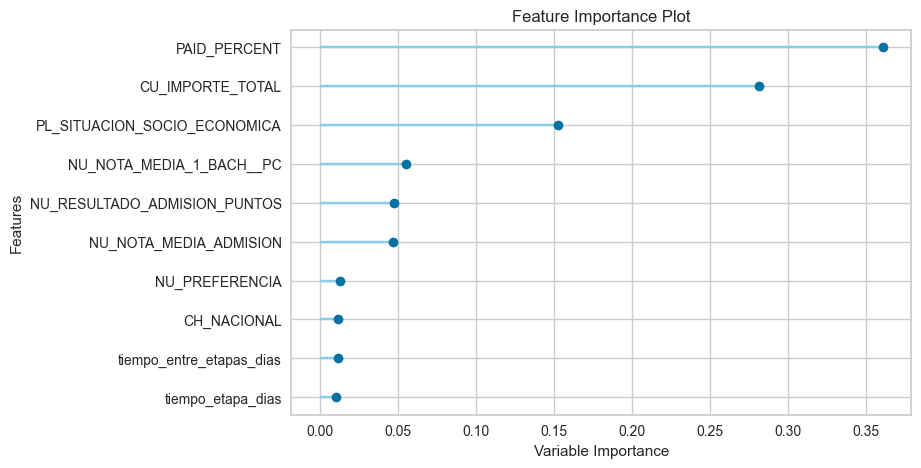

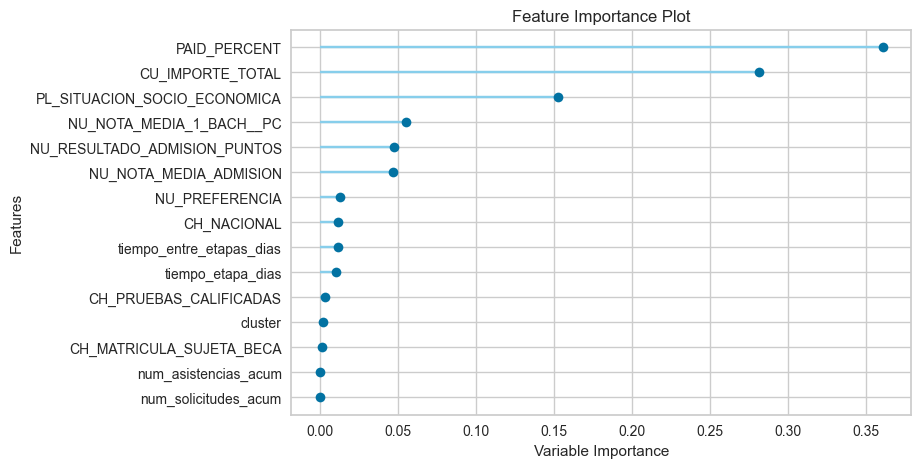

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['NU_NOTA_MEDIA_ADMISION',
                                              'NU_NOTA_MEDIA_1_BACH__PC',
                                              'NU_RESULTADO_ADMISION_PUNTOS',
                                              'PAID_PERCENT', 'CU_IMPORTE_TOTAL',
                                              'NU_PREFERENCIA',
                                              'PL_SITUACION_SOCIO_ECONOMICA',
                                              'tiempo_etapa_dias',
                                              'tiempo_entre_etapas_dias',
                                              'num_asistencias_acum',
                                              'num_sol...
                  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                         class_weight=None, criterion='gini',
   

In [6]:
# ============================================================
# SCRIPT · 03 MODELADO PREDICTIVO CON PYCARET (REVISADO FINAL)
# ============================================================

import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score
from pycaret.classification import (
    setup, compare_models, tune_model,
    predict_model, plot_model, save_model
)

# ============================================================
# 0️⃣ CARGA DEL DATASET
# ============================================================

ruta_dataset = r"..\datos\03. Datos analizados\dataset_clusterizado.csv"
df = pd.read_csv(ruta_dataset, sep=";")
target = 'target'

# ============================================================
# 0️⃣.1 FILTRAR SOLO GRADO (EXCLUYE MÁSTER)
# ============================================================

# Juan: si se va a hacer un modelado para máster, tenemos que quitar los registros
# de máster del entrenamiento del primer modelo y comparar los resultados con y sin
# master del modelo general (o de grado) ✅

if 'TITULACION' in df.columns:
    df = df[~df['TITULACION'].str.contains('MASTER', case=False, na=False)]
else:
    raise ValueError("❌ No existe la columna TITULACION")

# ============================================================
# 0️⃣.2 LIMPIEZA BÁSICA
# ============================================================

cols_id = ['ACCOUNTID', 'ID', 'ID18__PC', 'BIRTHDATE']
df = df.drop(columns=[c for c in cols_id if c in df.columns])
df = df.dropna(subset=[target])

# ============================================================
# 0️⃣.3 IMPUTACIÓN LÓGICA DE NA
# ============================================================

vars_cero_logico = [
    'NU_NOTA_MEDIA_ADMISION',
    'NU_NOTA_MEDIA_1_BACH__PC',
    'NU_RESULTADO_ADMISION_PUNTOS',
    'CU_IMPORTE_TOTAL',
    'CU_precioOrdinario_def__c',
    'CU_precioAplicado_def__c',
    'PAID_PERCENT'
]

for v in vars_cero_logico:
    if v in df.columns:
        df[v] = df[v].fillna(0)

df = df.fillna(0)

# ============================================================
# 1️⃣ SELECCIÓN DE VARIABLES
# ============================================================

# Juan: ¿Porqué se quita el PAID_PERCENT? En teoría ya se solucionó
# para poner los NA a cero y tendría sentido. Sobre todo porque es una
# variable que siempre sale entre las más importantes. ✅

vars_excluir = [
    'desmatriculado', 'MINIMUMPAYMENTPAYED',
    'CH_PAGO_SUPERIOR', 'STAGENAME', 'PL_SUBETAPA',
    'ACC_DTT_FECHAULTIMAACTIVIDAD', 'NAMEX',
    'YEARPERSONBIRTHDATE', 'PAID_AMOUNT',
    'PC1', 'PC2'
]

vars_modelado = [c for c in df.columns if c not in vars_excluir + [target]]

# ============================================================
# 2️⃣ SPLIT TEMPORAL
# ============================================================

cursos = df['PL_CURSO_ACADEMICO'].dropna().sort_values().unique()
curso_test = cursos[-2]
curso_excluido = cursos[-1]

train_df_full = df[~df['PL_CURSO_ACADEMICO'].isin([curso_test, curso_excluido])]
test_df_full  = df[df['PL_CURSO_ACADEMICO'] == curso_test]

X_train = train_df_full[vars_modelado]
y_train = train_df_full[target]
X_test  = test_df_full[vars_modelado]
y_test  = test_df_full[target]

# ============================================================
# 3️⃣ FILTRADO DE COLUMNAS PROBLEMÁTICAS
# ============================================================

object_cols = X_train.select_dtypes(include='object').columns.tolist()
const_cols = X_train.columns[X_train.nunique() <= 1].tolist()
pca_cols = ['PCA1', 'PCA2', 'PC1', 'PC2']

safe_cols = [
    c for c in X_train.columns
    if c not in object_cols + const_cols + pca_cols
]

train_df = X_train[safe_cols].copy()
train_df[target] = y_train

# ============================================================
# 4️⃣ SETUP PYCARET
# ============================================================

setup(
    data=train_df,
    target=target,
    session_id=42,
    normalize=True,
    fold=3,
    verbose=False,
    html=False
)

# ============================================================
# 5️⃣ MODELADO
# ============================================================

best_model = compare_models(
    include=['lr', 'dt', 'rf', 'lightgbm'],
    sort='AUC',
    turbo=True
)

best_model = tune_model(best_model, optimize='AUC', n_iter=10)

# ============================================================
# 6️⃣ VALIDACIÓN EN TEST
# ============================================================

test_df = X_test[safe_cols].reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

preds = predict_model(best_model, data=test_df)
preds[target] = y_test
preds['probabilidad_matricula'] = 1 - preds['prediction_score']

# ============================================================
# 7️⃣ DATASET TEST COMPLETO (TODAS LAS VARIABLES)
# ============================================================

# Juan: Meter el conjunto de datos test final con todas las variables
# (incluidas las descartadas) y todas las titulaciones. ✅

df_test_completo = test_df_full.reset_index(drop=True)
df_test_completo = pd.concat(
    [df_test_completo, preds[['probabilidad_matricula', 'prediction_label']]],
    axis=1
)

ruta_excel = r"..\datos\03. Datos analizados\test_grado_completo_con_scoring.xlsx"
df_test_completo.to_excel(ruta_excel, index=False)

# ============================================================
# 8️⃣ IMPORTANCIA DE VARIABLES
# ============================================================

plot_model(best_model, plot='feature')
plot_model(best_model, plot='feature_all')

# ============================================================
# 9️⃣ GUARDADO DEL MODELO
# ============================================================

save_model(best_model, r"..\datos\04. Modelos\modelo_final_grado")


                                    Model  Accuracy     AUC  Recall   Prec.  \
lightgbm  Light Gradient Boosting Machine    0.9896  0.9993    0.99  0.9905   

              F1   Kappa     MCC  TT (Sec)  
lightgbm  0.9902  0.9791  0.9791      0.24  


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 10 candidates, totalling 30 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
      Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.9833  0.9989  0.9857  0.9830  0.9844  0.9665  0.9665
1       0.9851  0.9988  0.9809  0.9911  0.9860  0.9702  0.9702
2       0.9869  0.9992  0.9837  0.9918  0.9877  0.9738  0.9738
Mean    0.9851  0.9990  0.9834  0.9886  0.9860  0.9702  0.9702
Std     0.0015  0.0002  0.0020  0.0040  0.0014  0.0030  0.0030


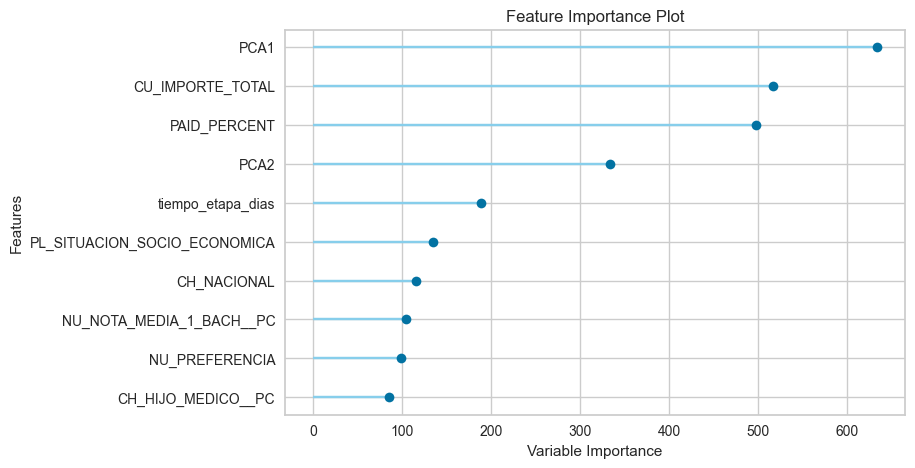

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['NU_NOTA_MEDIA_1_BACH__PC',
                                              'PAID_PERCENT', 'CU_IMPORTE_TOTAL',
                                              'NU_PREFERENCIA',
                                              'PL_SITUACION_SOCIO_ECONOMICA',
                                              'tiempo_etapa_dias',
                                              'tiempo_entre_etapas_dias', 'PCA1',
                                              'PCA2'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,...
                  LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                 colsample_bytree=1.0

In [7]:
# ============================================================
# SCRIPT · MODELADO PREDICTIVO MÁSTER CON PYCARET (FINAL)
# ============================================================

# Juan: si se va a hacer un modelado para máster, tenemos que quitar los registros
# de máster del entrenamiento del primer modelo y comparar los resultados con y sin
# master del modelo general (o de grado) ✅

import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score
from pycaret.classification import setup, compare_models, tune_model, predict_model, plot_model, save_model

# ============================================================
# 0️⃣ CARGA DEL DATASET
# ============================================================

ruta_dataset = r"..\datos\03. Datos analizados\dataset_clusterizado.csv"
df = pd.read_csv(ruta_dataset, sep=";")
target = 'target'

# ============================================================
# 0️⃣.1 FILTRAR SOLO MÁSTER
# ============================================================

df = df[df['TITULACION'].str.contains('MASTER', case=False, na=False)]

# ============================================================
# 0️⃣.2 LIMPIEZA E IMPUTACIÓN
# ============================================================

df = df.drop(columns=['ACCOUNTID', 'ID', 'ID18__PC', 'BIRTHDATE'], errors='ignore')
df = df.dropna(subset=[target])

# Juan: Aquí también entra el PAID_PERCENT y el porcentaje de beca. ✅
vars_cero_logico = [
    'NU_NOTA_MEDIA_ADMISION',
    'NU_NOTA_MEDIA_1_BACH__PC',
    'NU_RESULTADO_ADMISION_PUNTOS',
    'CU_IMPORTE_TOTAL',
    'CU_precioOrdinario_def__c',
    'CU_precioAplicado_def__c',
    'PAID_PERCENT'
]

for v in vars_cero_logico:
    if v in df.columns:
        df[v] = df[v].fillna(0)

df = df.fillna(0)

# ============================================================
# 1️⃣ VARIABLES
# ============================================================

# Juan: Aquí igual, sólo me rechina que el PAID_PERCENT se descarte. ✅
vars_excluir = [
    'desmatriculado', 'MINIMUMPAYMENTPAYED', 'CH_PAGO_SUPERIOR',
    'STAGENAME', 'PL_SUBETAPA', 'ACC_DTT_FECHAULTIMAACTIVIDAD',
    'NAMEX', 'YEARPERSONBIRTHDATE', 'PAID_AMOUNT', 'PC1', 'PC2'
]

vars_modelado = [c for c in df.columns if c not in vars_excluir + [target]]

# ============================================================
# 2️⃣ SPLIT TEMPORAL
# ============================================================

cursos = df['PL_CURSO_ACADEMICO'].sort_values().unique()
train_df = df[df['PL_CURSO_ACADEMICO'] != cursos[-2]]
test_df  = df[df['PL_CURSO_ACADEMICO'] == cursos[-2]]

X_train = train_df[vars_modelado]
y_train = train_df[target]
X_test  = test_df[vars_modelado]
y_test  = test_df[target]

# ============================================================
# 3️⃣ FILTRADO
# ============================================================

safe_cols = [
    c for c in X_train.columns
    if X_train[c].dtype != 'object' and X_train[c].nunique() > 1
]

train_df = X_train[safe_cols]
train_df[target] = y_train

# ============================================================
# 4️⃣ PYCARET
# ============================================================

setup(
    data=train_df,
    target=target,
    session_id=42,
    normalize=True,
    fold=3,
    verbose=False,
    html=False
)

best_model = compare_models(include=['lightgbm'], sort='AUC')
best_model = tune_model(best_model, optimize='AUC')

# ============================================================
# 5️⃣ SCORING Y DATASET COMPLETO
# ============================================================

preds = predict_model(best_model, data=X_test[safe_cols])
preds['probabilidad_matricula'] = preds['prediction_score']

# Juan: conjunto de datos test con todas las variables, target y probabilidad. ✅

df_test_completo = test_df.reset_index(drop=True)
df_test_completo = pd.concat(
    [df_test_completo, preds[['probabilidad_matricula', 'prediction_label']]],
    axis=1
)

ruta_excel = r"..\datos\03. Datos analizados\test_master_completo_con_scoring.xlsx"
df_test_completo.to_excel(ruta_excel, index=False)

# ============================================================
# 6️⃣ IMPORTANCIA Y GUARDADO
# ============================================================

plot_model(best_model, plot='feature')
save_model(best_model, r"..\datos\04. Modelos\modelo_final_master")
